In [998]:
import requests
import json

url = '10.168.20.20:5010'
entries = ['5b491e5bd7f17a0025e48d7c']
rolesa = '5afdb8cf93beb10025c13f4f'

#url = 'localhost:5010'
#entries = ['5b3ec47706f9e50f2f36acc8', '5b3fd54906f9e50f2f36acc9']
#rolesa = '593f49be42d3ed97390f25a7'

In [999]:
pipeline = [
    {'$match': {'_id': {'$in': entries}, 'roles._id': rolesa}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {
                    'name': 1, 'family': 1, 
                    'deps._id': 1, 'deps.endpoint': 1, 
                    'nodes._id': 1, 'nodes.deps': 1, 'nodes.name': 1, 'nodes.family': 1, 'nodes.servers': 1
                 }
    }
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()

In [1000]:
import sys
import os
import numpy as np
cwd = os.getcwd()
spltted = cwd.split('/')[:-1]
sys.path.append('/'.join(spltted))

import networkx as nx
from app.services.gridOrchestrator import GridOrchestrator
from app.libs.network.baseNetwork import BaseNetwork
from app.libs.histograms.histogram import Histogram
from app.libs.histograms.grid import GridHistogram

from svgwrite import Drawing

network = BaseNetwork()
network.make(data.get('items')).get_graph()

In [1001]:
mapping_style = {
    'aws': '.dark{fill:#c4692c;}.light{fill:#f58536;}.darker{fill:#a0501a;}.white{fill:#fff;}',
    'default': '.a{fill:#c4692c;}.b{fill:#f58536;}.c{fill:#a0501a;}.white{fill:#fff;}'
}

s_apps = {
    'viewBox': (0, 0, 266.4, 316.32),
    'els': [
        {
            'shape': 'polyline',
            'args': {
                'points': '133.2 316.32 0 238.16 0 118.16 133.2 196.32 133.2 316.32',
                'class_': 'light'
            }
        },
        {
            'shape': 'polyline',
            'args': {
                'points': '133.2 316.32 266.4 238.16 266.4 78.16 133.2 196.32 133.2 316.32',
                'class_': 'dark'
            }
        },
        {
            'shape': 'polyline',
            'args': {
                'points': '133.2 0 0 118.16 133.2 196.32 266.4 78.16 133.2 0',
                'class_': 'darker'
            }
        },
        {
            'shape': 'path',
            'args': {
                'd': 'M17.8,198.81,112,254V206.65L17.8,151.41ZM81.88,198l22.67,13.3v30.82l-22.67-13.3ZM53.12,181.12l22.33,13.1V225l-22.33-13.1ZM24.81,164.45l22,13v30.82l-22-12.91Z',
                'class_': 'white'
            }
        }
    ]
}

m_apps = {
    'viewBox': (0, 0, 266.4, 505),
    'els': [
        {
            'shape': 'polyline',
            'args': {
                'points': '133.2 505 0 428 0 78.16 133.2 154 133.2 505',
                'class_': 'dark'
            }
        },
        {
            'shape': 'polyline',
            'args': {
                'points': '133.2 0 0 78.16 133.2 154 266.4 78.16 133.2 0',
                'class_': 'darker'
            }
        },
        {
            'shape': 'polyline',
            'args': {
                'points': '133.2 505 266.4 428 266.4 78.16 133.2 154 133.2 505',
                'class_': 'light'
            }
        },
        {
            'shape': 'path',
            'args': {
                'd': 'M16.8,128.73l-.08,46.34,93.88,53.51.34-47.35Zm28.89,55.16L23.74,171.42l.07-31.08,22,12.3Zm28.6,16.24L52,187.47l.12-31.29,22.33,12.5Zm29,16.49L80.7,203.77l.17-31.5L103.54,185Z',
                'class_': 'white'
            }
        },
        {
            'shape': 'path',
            'args': {
                'd': 'M16.63,236.75l93.52,54.83.34-47L16.7,190.74Zm63.9-1.61,22.59,13-.22,31.42L80.36,266.4Zm-28.64-16.5,22.24,12.82L74,262.67l-22.21-13ZM23.68,202.39,45.59,215l-.11,31L23.62,233.25Z',
                'class_': 'white'
            }
        }
    ]
}

                
grid = {
    'viewBox': (0, 0, 266.4, 156.32),
    'els': [{
        'shape': 'polyline',
        'args': {
            'points': '133.2 0 0 78.16 133.2 156.32 266.4 78.16',
            'fill': "#a0501a"}}]
}
        
mapping = {
    'grid.base': grid,
    'applications.small': s_apps,
    'applications.medium': m_apps
}

class Creator(object):
    def __init__(self, assets):
        self._assets = assets

    def make(self):
        points = self.get_args('points')
        
        if points:
            points = self.getPoints(points)
            self.set_args('points', points)
            
        return self._assets
    
    def get_args(self, label):
        return self._assets.get(label)
    
    def set_args(self, label, value):
        self._assets[label] = value
    
    def getPoints(self, points):
        prepared = []
        splitted = points.split(' ')

        tmp = None
        for item in splitted:
            if tmp:
                cons = (tmp, item)
                prepared.append(cons)
                tmp = None
            else:
                tmp = item
        
        return prepared

class ManageAssets(object):
    def __init__(self, symbol, creator=Creator):
        self._symbol_assets = symbol
        self._creator = creator
    
    def polyline(self, opt={}):
        return self._symbol_assets.dwg.polygon(**opt)
    
    def path(self, opts):
        return self._symbol_assets.dwg.path(**opts)
    
    def create(self, configs):
        objs = []
        items = configs.get('els')
        
        for item in items:
            args = item.get('args')
            shape = item.get('shape')
            opts = self._creator(args).make()
            
            obj = getattr(self, shape)(opts)
            objs.append(obj)
        
        return objs

In [1002]:
class DrawArea(object):
    def __init__(self, off, size, max_x, max_y):
        self._off = off
        self._size = size
        self._max_x = max_x
        self._max_y = max_y

    def area_x(self):
        size_x = (self._size[0] / 2)
        area_x = size_x * (self._max_x + self._max_y + 1) * self._off[0]
        
        if self._off[0] > 1:
            area_x = area_x - (size_x / self._off[0])
        
        return area_x
    
    def area_y(self):
        size_y = (self._size[1] / 4)

        area_y = (size_y * (self._max_x + (self._max_y )) * self._off[1]) + (self._size[1])
        return area_y
    
    def area(self):
        area_x = self.area_x()
        area_y = self.area_y()
        return (area_x, area_y)


class ManageStyle(object):
    
    def __init__(self, draw, smap=mapping_style):
        self.dwg = draw
        self._used_styles = []
        self._smap = smap
    
    def stylish(self, template):
        
        if template not in self._used_styles:
            tpl = self.get_template(template)
            self.attach_style(tpl)
            
            self._used_styles.append(template)
    
    def get_template(self, name, dft='default'):
        if name in self._smap:
            return self._smap[name]
        
        return self._smap[dft] 
            
    def attach_style(self, styles):
        stl = self.dwg.style(styles)
        self.dwg.defs.add(stl)
    
class Symbol(object):
    
    def __init__(self, draw=Drawing, mstyle=ManageStyle):
        self.dwg = draw
        self._s_basket = {}
        self._proportion = {}
        
        self._factor_proportion = 10
        
        self._manager_style = mstyle(self.dwg)
    
    def create_symbol(self, name, objs, viewbox):
        symbol = self.dwg.symbol(id=name)
        self.dwg.defs.add(symbol)
        
        symbol.viewbox(*viewbox)
        symbol.fit(vert='bottom')
        
        for obj in objs:
            symbol.add(obj)
        
        self._s_basket[name] = symbol
    
    def use_symbol(self, name, pos, opts={}):
        syb = self._s_basket[name]
        return self.dwg.use(syb, insert=pos, **opts)
    
    def get_proportion(self, k):
        return self._proportion[k]
    
    def set_proportion(self, k, val):
        x = val[0] / self._factor_proportion
        y = val[1] / self._factor_proportion
        self._proportion[k] = (x, y)
        
    def square(self, pos, size, opts={}):
        return self.dwg.rect(insert=pos, size=size, **opts)
    
    def text(self, title, pos, opt={}):
        return self.dwg.text(title, insert=pos, **opt)
    
    
        
class SymbolAssets(Symbol):
    
    def __init__(self, draw, assets=mapping, manager=ManageAssets):
        super().__init__(draw)
        
        self._map_assets = assets
        self._manager = manager(self)
    
    def asset(self, asset, template, pos, size):
        if not asset in self._s_basket:
            configs = self._map_assets[asset]
            create = self._manager.create(configs)
            
            viewbox = configs.get('viewBox')
            self.create_symbol(asset, create, viewbox)
            
            self.set_proportion(asset, (viewbox[2], viewbox[3]))
            
            self._manager_style.stylish(template)
        
        
        factor = self.get_proportion(asset)
        
        #sz = (size[0] - factor[0], size[1] - factor[1])
        #print(sz)
        return self.use_symbol(asset, pos, {'size': size})


In [1003]:
class MatrixRotation(object):
    
    def __init__(self, max_x, max_y, size, off):
        self._off = off
        self._size = size
        
        self._rect_y = (self._size[1] / 4) * max_x * self._off[1]

    def cal_offy(self, x, y, size):
        size_y = (self._size[1] * 0.5) / 2
        return self._rect_y - (size_y * x * self._off[0]) + (size_y * y * self._off[1])
    
    def cal_offx(self, x, y, size):
        size_x = self._size[0] / 2
        return (size_x * y * self._off[1]) + (size_x * x * self._off[0])
    
class DrawTemplateSVG(object):
    def __init__(self, tmax, darea=DrawArea, symbols=SymbolAssets, matrix=MatrixRotation):
        self._off = (1.4, 1.4)
        self._size = (600, 880)

        self._matrix = matrix(tmax[0], tmax[1], self._size, self._off)
        self._area = darea(self._off, self._size, tmax[0]+200, tmax[1]).area()

        self.dwg = Drawing('test.svg', size=self._area)
        self._symbols = symbols(self.dwg)
        
        self.setup()
    
    def setup(self):
        symbol = self._symbols.square((0,0), size=self._area, opts={'fill': "#ededed"})
        self.add(symbol)
    
    def draw_app(self, pos, item):
        node = item[3]
        name = node.get('name', '-')
        size = item[2]
        
        pos = self.cal_off(pos, size)
        
        symbol = self._symbols.asset('grid.base', None, (pos[0], pos[1]), self._size)
        self.add(symbol)
        
        symbol = self._symbols.square(pos, self._size, {'fill': "rgb(255, 255, 0)", 'fill-opacity': '0.25'})
        self.add(symbol)
        
        symbol = self._symbols.text(name, pos)
        self.add(symbol)
        
        asset = 'applications.small'
        template = 'aws'
        
        
        
        servers = node.get('servers')
        qtd = 1
        if servers:
            qtd = len(servers)
            
        
        size = (self._size[0]/5, self._size[1]/5) 
        size = (self._size[0] * 0.5, self._size[1] * 0.5)
        
        
        
        off_x = size[0] * 0.5
        off_y = size[1] - (size[1] * 0.45)
        
        pos1 = (pos[0] + off_x, pos[1] + off_y)
        print(size)
        symbol = self._symbols.asset(asset, template, pos1, size)
        self.add(symbol)
        
        
        
        
        off_x = 0
        off_y = (self._size[1] * 0.75) - size[1]
        
        pos2 = (pos[0] + off_x, pos[1] + off_y)
        print(size)
        symbol = self._symbols.asset(asset, template, pos2, size)
        self.add(symbol)
    
        
        
        off_x = self._size[0] * 0.25
        off_y = self._size[1] * 0.5
        
        pos3 = (pos[0] + off_x, pos[1] + off_y)
        print(size)
        symbol = self._symbols.asset(asset, template, pos3, size)
        self.add(symbol)
        
        symbol = self._symbols.square(pos3, size, {'fill': "#fc9c9c", 'fill-opacity': '0.25'})
        self.add(symbol)
        
        
        
        
        
    def draw_grid(self, pos, name, size):
        pos = self.cal_off(pos, size)
        
        symbol = self._symbols.square(pos, self._size, {'fill': "#fc9c9c", 'fill-opacity': '0.50'})
        self.add(symbol)
        
        symbol = self._symbols.asset('grid.base', None, (pos[0], pos[1]), self._size)
        self.add(symbol)
        
    def cal_off(self, pos, size):
        x = self._matrix.cal_offx(*pos, size)
        y = self._matrix.cal_offy(*pos, size)
        
        return (x, y)

    def add(self, symbol):
        self.dwg.add(symbol)
        
    def save(self):
        self.dwg.save()
        return self.dwg.get_xml()


class DrawLayout(object):
    def __init__(self, grid, index, draw=DrawTemplateSVG):
        
        self._grid = grid
        self._index = index
        
        self._max_x = max(self._grid, key=int)
        self._max_y = max(self._grid[0], key=int)
        
        self.drawer = draw((self._max_x, self._max_y))

    def draw_nodes(self):
        
        for col_k in range(self._max_x, -1, -1):
            if col_k in self._grid:
                columm = self._grid[col_k]
                max_y = max(self._grid[col_k], key=int)
            
                for line_k in range(0, max_y+1):
                    if line_k in self._grid[col_k]:
                        
                        label = self._grid[col_k][line_k]
                    
                        if label in self._index:
                            item = self._index[label]
                            self.drawer.draw_app((col_k, line_k), item)
                        else:
                            self.drawer.draw_grid((col_k, line_k), '-', 1)

                        
        
        return self
    
    def draw_connections(self, edges):
        for edge in edges:
            pos = []
            w = []
            size = []
            
            for i in range(2):
                ipos = self._index[edge[i]]
                pos.append(ipos)
                w.append(ipos[0])
                size.append(ipos[2])

            #self.drawer.draw_connect(*pos, *w, *size)
            
        return self
    
    def save(self):
        return self.drawer.save()

-------------------------
(300.0, 440.0)
(300.0, 440.0)
(300.0, 440.0)


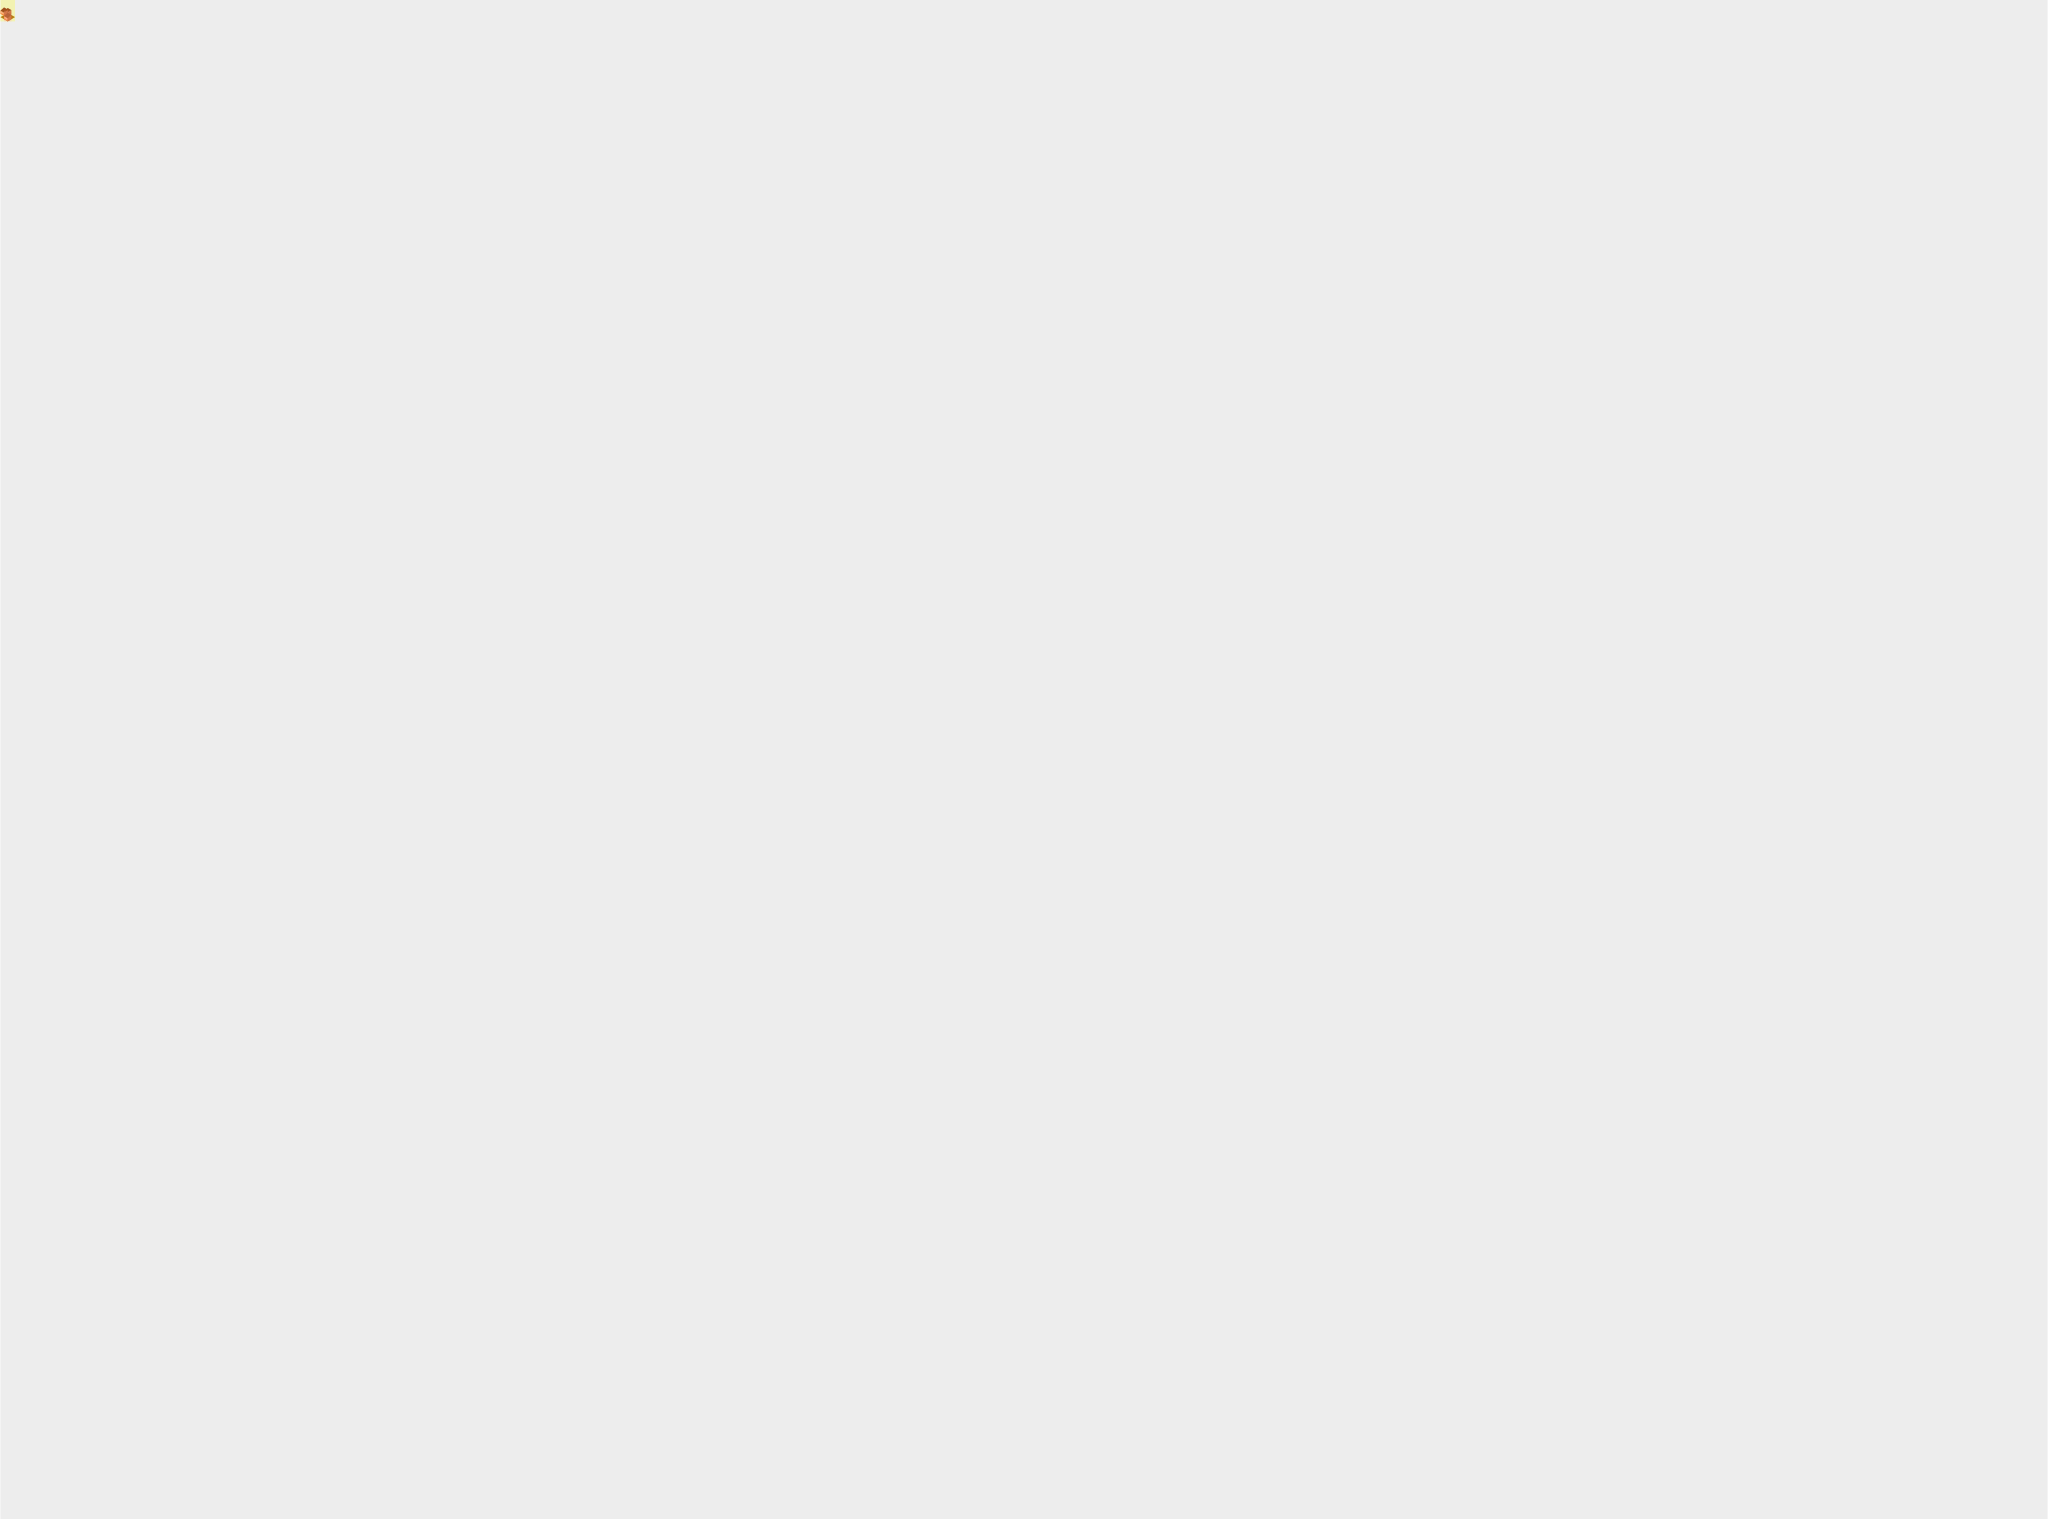

In [1004]:
from IPython.display import SVG, display

print("-------------------------")
Orchestration = GridOrchestrator(network.graph)
Orchestration.create(entries)

#print(Orchestration.get_grid().get_index())
#print(Orchestration.get_grid().get_grid())

Layout = DrawLayout(Orchestration.get_grid().get_grid(), Orchestration.get_grid().get_index())


Layout.draw_nodes()
Layout.draw_connections(network.graph.edges(data='endpoint'))
Layout.save()
   
display(SVG(filename='test.svg'))